In [1]:
import numpy as np
import pandas as pd
import time

from functools import partial
from scipy.stats import randint, uniform
from sim_lib import simulation

pd.options.mode.chained_assignment = None


In [2]:
def eps_greedy(history: pd.DataFrame, eps: float):
    if uniform.rvs() < eps:
        n = history.shape[0]
        return history.index[randint.rvs(0, n)]

    ctr = history['clicks'] / (history['impressions'] + 10)
    n = np.argmax(ctr)
    return history.index[n]

policy = partial(eps_greedy, eps=0.08)

In [3]:
# seed for homework
np.random.seed(seed=384758917)

start = time.time()
output, regret_history_greedy = simulation(policy, n=200000)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


436.2190899848938

In [4]:
# baseline regret
output['regret'], output['regret']/output['rounds'],  output['total_banners']

(2792.237649427154, 0.01396118824713577, 174)

Я решила выбрать Thompson Sampling потому что он довольно понятно теоретически обоснован и в случае бернуллиевского бандита (а у нас он логичен в силу того, что мы рассматриваем события 0/1 клика по баннеру) обновления параметров довольно просты

In [5]:
from collections import defaultdict

class ThompsonSampling:
    # в качестве параметров по умолчанию единицы
    # потому что это соответствует равномерному распределению, а баннеры изначально все равны
    def __init__(self, a=1, b=1):
        self.a_init = a
        self.b_init = b
        self.a_params = defaultdict(lambda: self.a_init)
        self.b_params = defaultdict(lambda: self.b_init)
        self.prev_ind = -1
        
    def thompson_sampling(self, history: pd.DataFrame):
        betas = []
        banner_ids = history.index.values
        
        # обновляем баннер, который выбрали на предыдущем шаге
        # можно было бы и единицами, но раз у нас сагрегированные значения в истории, то и так подойдет
        if self.prev_ind in banner_ids:
            self.a_params[self.prev_ind] = history.loc[self.prev_ind]['clicks'] + self.a_init
            self.b_params[self.prev_ind] = history.loc[self.prev_ind]['impressions'] - history.loc[self.prev_ind]['clicks'] + self.b_init
        
        for banner_id in banner_ids:
            a = self.a_params[banner_id]
            b = self.b_params[banner_id]
            
            # сэмплим по одному значению на баннер
            betas.append(np.random.beta(a, b, size=1))

        max_reward_ind = np.argmax(betas)
        
        # запоминаем баннер, ведь данные о reward придут только на слежующем шаге
        self.prev_ind = banner_ids[max_reward_ind]
        
        return self.prev_ind
    
ts = ThompsonSampling()
policy = ts.thompson_sampling

In [6]:
# seed for homework
np.random.seed(seed=384758917)

start = time.time()
output, regret_history_thompson = simulation(policy, n=200000)
end = time.time()
end - start

1 impressions have been simulated
10001 impressions have been simulated
20001 impressions have been simulated
30001 impressions have been simulated
40001 impressions have been simulated
50001 impressions have been simulated
60001 impressions have been simulated
70001 impressions have been simulated
80001 impressions have been simulated
90001 impressions have been simulated
100001 impressions have been simulated
110001 impressions have been simulated
120001 impressions have been simulated
130001 impressions have been simulated
140001 impressions have been simulated
150001 impressions have been simulated
160001 impressions have been simulated
170001 impressions have been simulated
180001 impressions have been simulated
190001 impressions have been simulated


380.49015712738037

Кажется работает даже быстрее e-greedy, но нужно больше запусков чтобы убедится.

In [7]:
# thomson regret

output['regret'], output['regret']/output['rounds'],  output['total_banners']

(1471.230717361168, 0.00735615358680584, 179)

Получилось гораздо меньше, чем когда мы использовали жадную стратегию

Посмотрим, получилось ли у нас приблится к логарифмической кривой

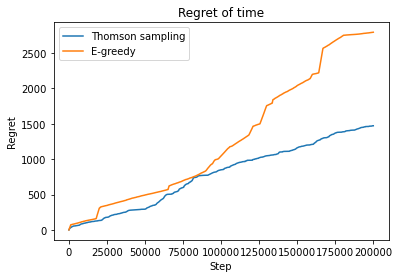

In [11]:
import matplotlib.pyplot as plt

plt.plot(range(200000), regret_history_thompson, label = 'Thomson sampling')
plt.plot(range(200000), regret_history_greedy, label = 'E-greedy')

plt.xlabel('Step')
plt.ylabel('Regret')
plt.title("Regret of time")
plt.legend()
plt.show()

График regret для TS проходит ниже графика e-greedy!

Но на логарифмическую кривую не очень то похоже.

In [15]:
output['history']

,impressions,clicks,lifetime,p
154,156.0,0.0,16595.715595,0.000442
169,3736.0,144.0,11415.767481,0.039232
175,4496.0,596.0,11381.152627,0.137817
178,42.0,1.0,4959.290645,0.030834
